In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series/notebook/03_Deeplearning_models")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import src.transformer_v1 as tf

from torch.utils.data import DataLoader
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.optim as optim

In [4]:
with open('../../data/pv_forecast.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [7]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['dwpt', 'rhum', 'wspd', 'pres']])
pv[['dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['dwpt', 'rhum', 'wspd', 'pres']])

In [8]:
pv = pv.set_index('datetime')

In [9]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,21,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,15,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [10]:
iw = 24*7
ow = 24
num_feature = 5

train_dataset = tf.windowDataset(pv_train[['power_scale', 'rhum', 'dwpt', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)
test_dataset = tf.windowDataset(pv_test[['power_scale', 'rhum', 'dwpt', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)

train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=16)

In [11]:
len(train_loader)

6

In [12]:
len(test_loader)

1

# transformer

- 시계열 데이터 transformer 적용이 목표이기 때문에 최대한 간단한 구조로 적용

- positional embedding 적용 x

- encoder, decoder 모두 1개의 layer

- target seq의 경우 teacher force prop 1/0 두가지로 적용

# teacher forcing = 0

In [13]:
# !pip install wandb

     |████████████████████████████████| 1.8 MB 26.8 MB/s 
     |████████████████████████████████| 181 kB 50.7 MB/s 
     |████████████████████████████████| 144 kB 51.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0b442249a7bd3cd6c0904cf3029ded54c4564d1e0929e95c36b52a9f2ec2d15f
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [14]:
import wandb

In [15]:
wandb.init(name='gradient_clipping', project="transformer", entity="yyyyyjkim")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [16]:
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 1000,
    "d_model": 5,
    "nhead": 5,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dim_feedforward": 128
}

In [17]:
device='cuda'
model = tf.transformer(d_model=wandb.config["d_model"], 
                       nhead=wandb.config["nhead"], 
                       num_encoder_layers=wandb.config["num_encoder_layers"], 
                       num_decoder_layers=wandb.config["num_decoder_layers"], 
                       dim_feedforward=wandb.config["dim_feedforward"]).to(device)

optimizer = optim.Adam(model.parameters(), lr = wandb.config['learning_rate'])
criterion = nn.MSELoss()

In [18]:
# multihead attention layer 에서 수정
model.transformer.decoder.layers[0].multihead_attn.__class__._forward = tf.attn_forward
for layer in model.transformer.decoder.layers:
    layer.multihead_attn.forward = layer.multihead_attn._forward

In [19]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,256 trainable parameters


In [20]:
# 파라미터 초기화
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

transformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=5, out_features=5, bias=True)
          )
          (linear1): Linear(in_features=5, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=5, bias=True)
          (norm1): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonD

In [21]:
wandb.watch(model, log='all', log_freq=10)

pbar = tqdm(range(wandb.config['epochs']))
for epoch in pbar:
    *result_train, train_loss = tf.train(model, train_loader, 24, optimizer, criterion, device='cuda')
    *result_test, test_loss = tf.predict(model, test_loader, 24, criterion, device='cuda')
    torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
    wandb.log({"train_loss": train_loss, "test_loss": test_loss})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
wandb.finish()

test_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.02584
train_loss,0.01709


# predict

In [23]:
pred = result_test[0]
true = result_test[1]
attention = result_test[2]

pred = power_scaler.inverse_transform(pred[:,:,0].reshape(-1,1))
true = power_scaler.inverse_transform(true[:,:,0].reshape(-1,1))

In [24]:
pv_test = pv.loc[datetime(2006,12,22,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)].copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


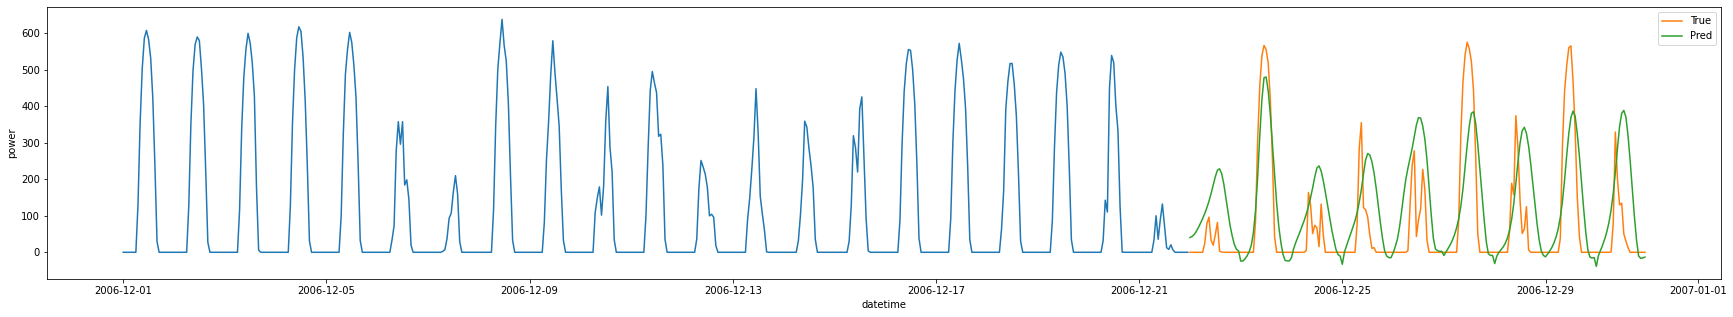

In [25]:
# gradient clipping
plt.figure(figsize=(30,5))
sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()

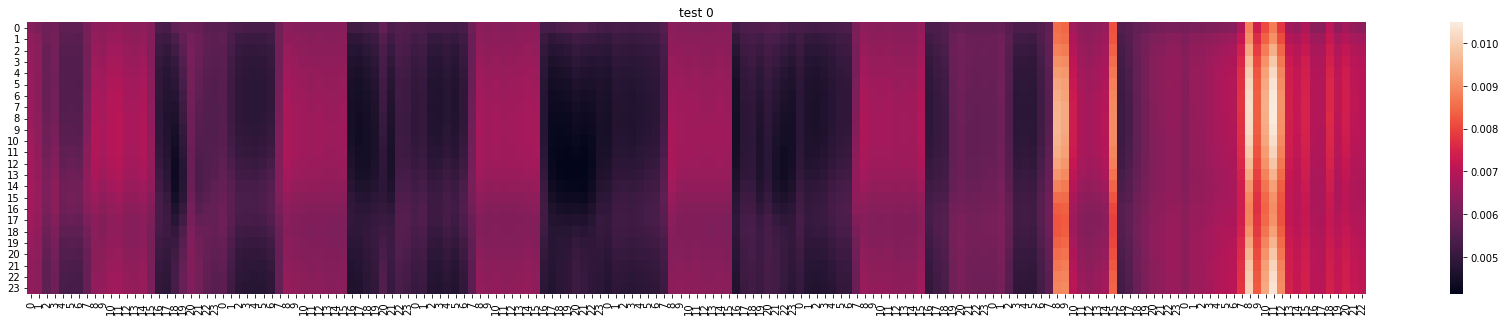

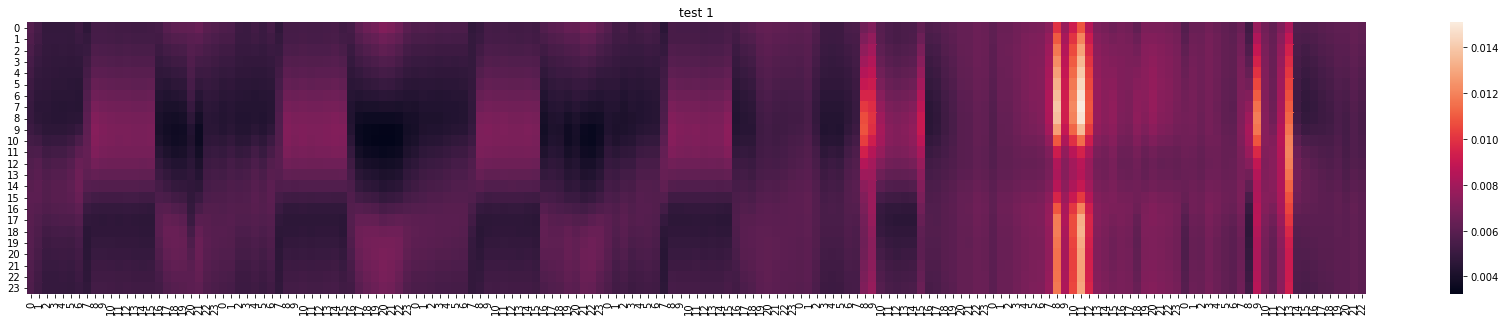

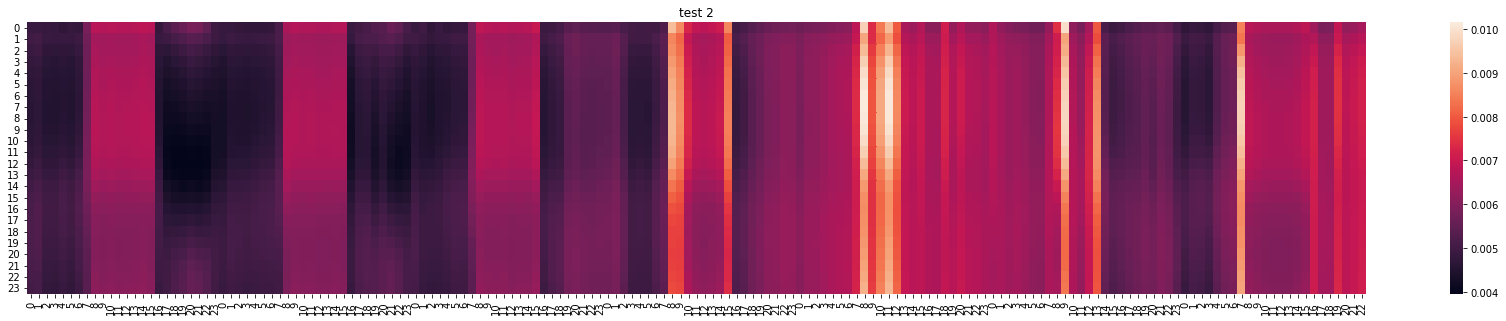

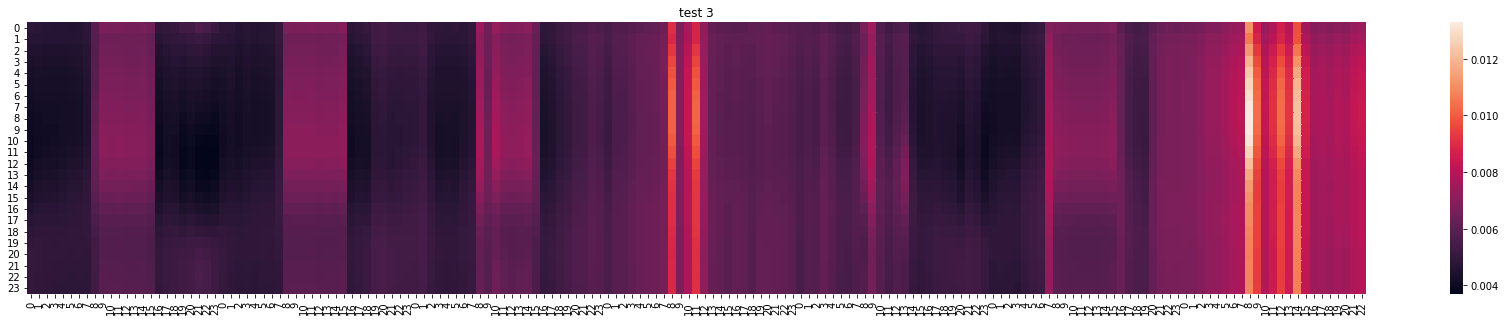

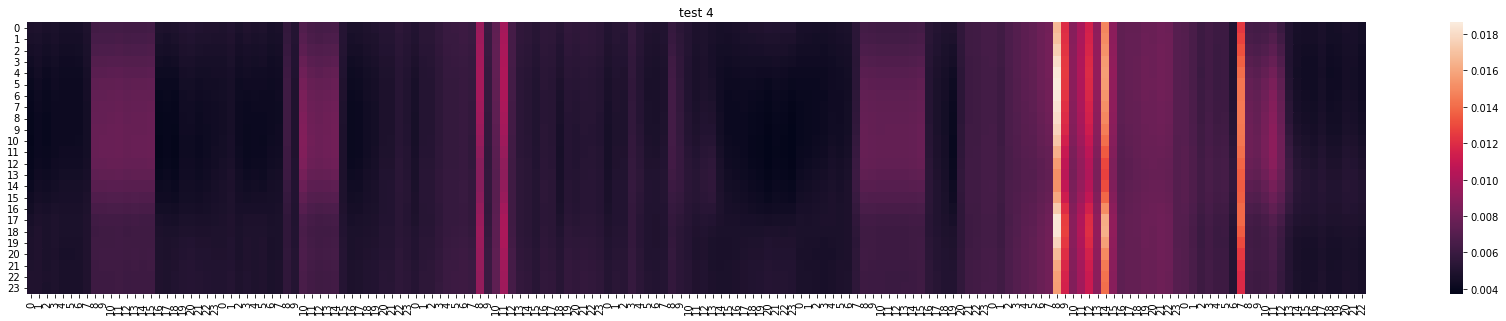

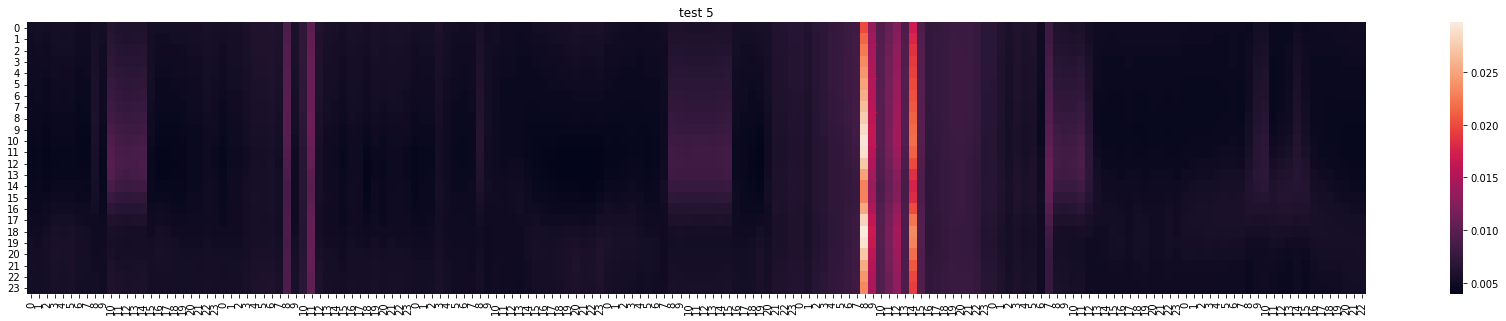

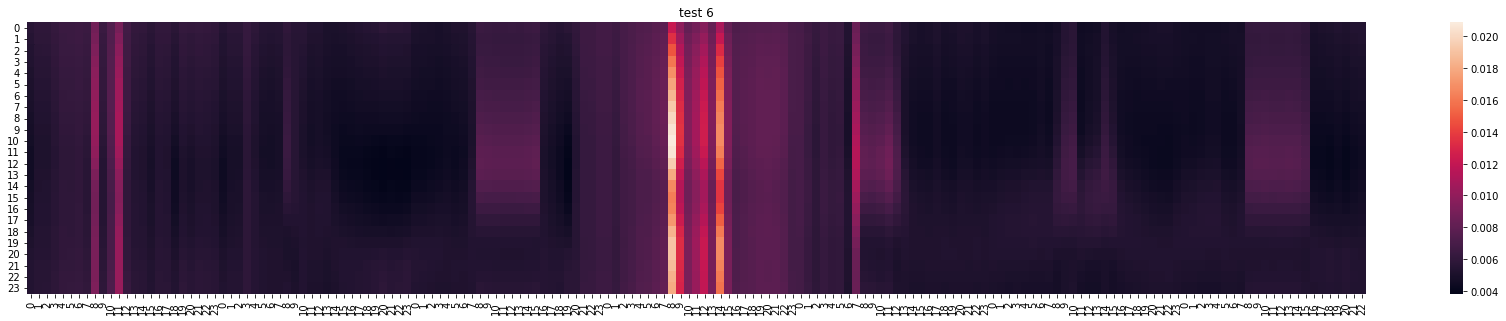

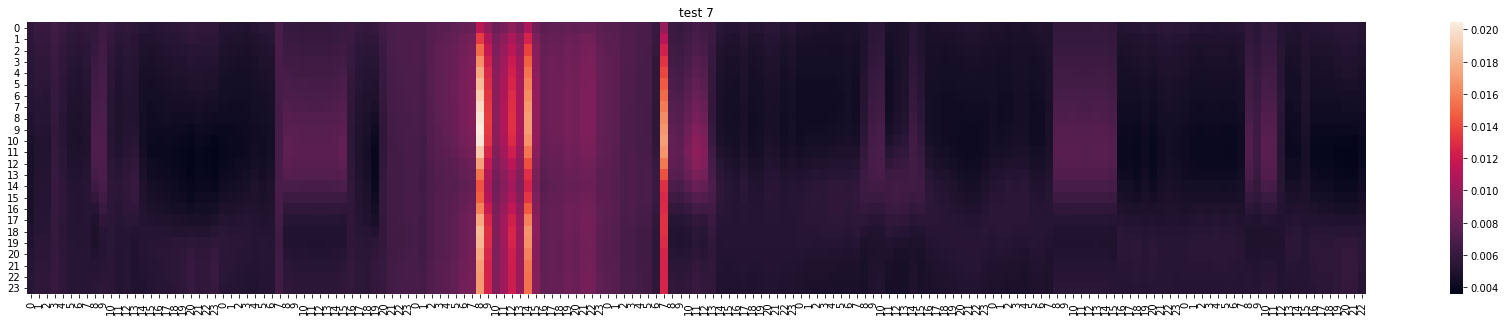

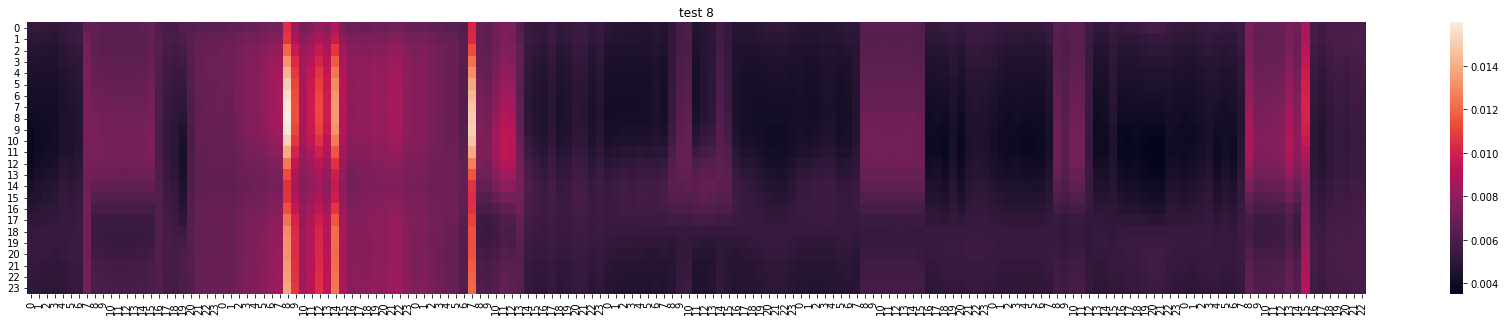

In [26]:
# 2006.12.22 이후 태양열 발전량 예측에 대한 attention energy 시각화
for i, att in enumerate(attention):
    plt.figure(figsize=(30,5))
    sns.heatmap(att, xticklabels=[i%24 for i in range(167)])
    plt.title(f"test {i}")
    plt.show()